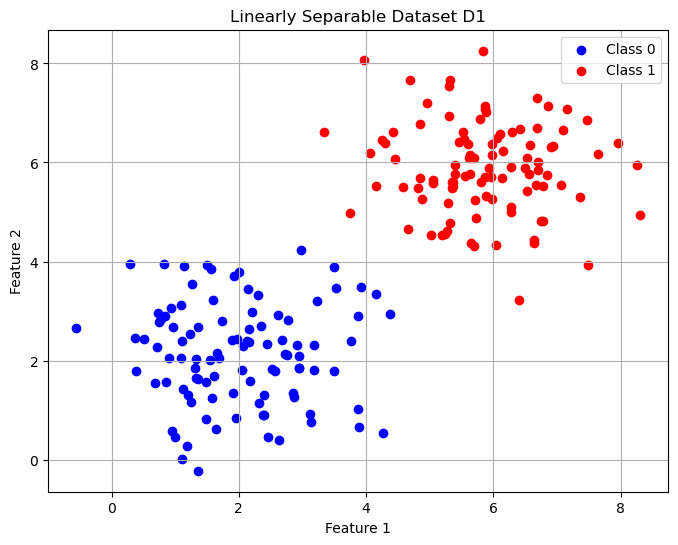

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# 100 points class 0, centered at (2, 2)
class_0 = np.random.randn(100, 2) + np.array([2, 2])
labels_0 = np.zeros(100)

# 100 points class 1, centered at (6, 6)
class_1 = np.random.randn(100, 2) + np.array([6, 6])
labels_1 = np.ones(100)

# D1 gull
X1 = np.vstack((class_0, class_1))
y1 = np.hstack((labels_0, labels_1))

y1 = np.where(y1 == 0, -1, 1)


plt.figure(figsize=(8, 6))
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')
plt.title("Linearly Separable Dataset D1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


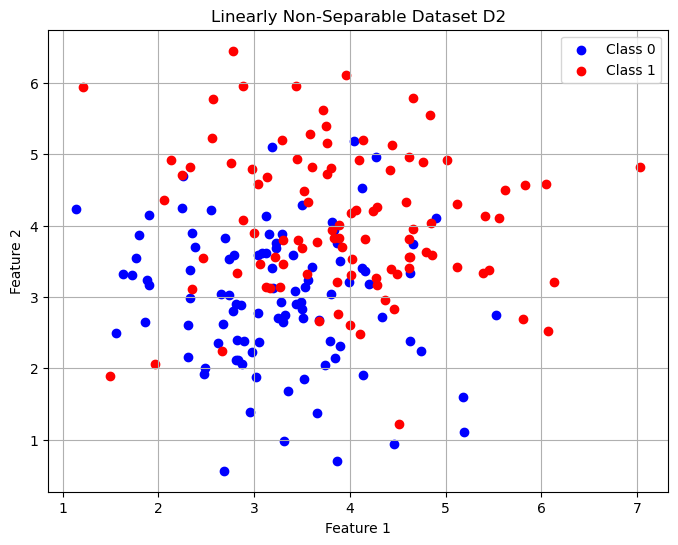

In [70]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

# 100 points for class 0 around (3, 3)
class_0_ns = np.random.randn(100, 2) + np.array([3, 3])
labels_0_ns = np.zeros(100)

# 100 points for class 1 around (4, 4) => overlap
class_1_ns = np.random.randn(100, 2) + np.array([4, 4])
labels_1_ns = np.ones(100)

# D2 full
X2 = np.vstack((class_0_ns, class_1_ns))
y2 = np.hstack((labels_0_ns, labels_1_ns))


y2 = np.where(y2 == 0, -1, 1)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(class_0_ns[:, 0], class_0_ns[:, 1], color='blue', label='Class 0')
plt.scatter(class_1_ns[:, 0], class_1_ns[:, 1], color='red', label='Class 1')
plt.title("Linearly Non-Separable Dataset D2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


In [71]:
def split_data(X, y):
    idx_neg = np.where(y == -1)[0]
    idx_pos = np.where(y == 1)[0]
    np.random.shuffle(idx_neg)
    np.random.shuffle(idx_pos)

    test_idx = np.concatenate([idx_neg[:10], idx_pos[:10]])
    train_idx = np.setdiff1d(np.arange(len(y)), test_idx)

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

X1_train, y1_train, X1_test, y1_test = split_data(X1, y1)
X2_train, y2_train, X2_test, y2_test = split_data(X2, y2)





In [72]:
class HardMarginSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    dw = 2 * self.lambda_param * self.w
                    self.w -= self.lr * dw
                else:
                    dw = 2 * self.lambda_param * self.w - np.dot(x_i, y[idx])
                    db = -y[idx]
                    self.w -= self.lr * dw
                    self.b -= self.lr * db

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


In [74]:
class SoftMarginSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[idx] * x_i)
                    self.b -= self.lr * (-y[idx])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [75]:
class TwoLayerMLP:
    def __init__(self, input_dim, hidden_dim, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters
        self.hidden_dim = hidden_dim

        self.W1 = np.random.randn(input_dim, hidden_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, 1)
        self.b2 = np.zeros((1, 1))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_deriv(self, Z):
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def fit(self, X, y):
        y = y.reshape(-1, 1)
        for _ in range(self.n_iters):
            # Forward
            Z1 = X @ self.W1 + self.b1
            A1 = self.relu(Z1)
            Z2 = A1 @ self.W2 + self.b2
            A2 = self.sigmoid(Z2)

            # binary cross entropy
            m = y.shape[0]
            dZ2 = A2 - ((y + 1) / 2)  # map labels from [-1, 1] to [0, 1]
            dW2 = A1.T @ dZ2 / m
            db2 = np.sum(dZ2, axis=0, keepdims=True) / m

            dA1 = dZ2 @ self.W2.T
            dZ1 = dA1 * self.relu_deriv(Z1)
            dW1 = X.T @ dZ1 / m
            db1 = np.sum(dZ1, axis=0, keepdims=True) / m

            # Update
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

    def predict(self, X):
        A1 = self.relu(X @ self.W1 + self.b1)
        A2 = self.sigmoid(A1 @ self.W2 + self.b2)
        return np.where(A2 > 0.5, 1, -1).flatten()


In [76]:
def evaluate(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_acc = np.mean(y_train_pred == y_train)
    test_acc = np.mean(y_test_pred == y_test)
    return train_acc, test_acc


In [77]:
print(X1_train.shape, y1_train.shape)
print(np.unique(y1_train))        


(180, 2) (180,)
[-1  1]


In [78]:
svm_hard = HardMarginSVM()
svm_hard.fit(X1_train, y1_train)
train_acc_hard, test_acc_hard = evaluate(svm_hard, X1_train, y1_train, X1_test, y1_test)
print("Hard-Margin SVM on D1 -> Train Acc:", train_acc_hard, "Test Acc:", test_acc_hard)


Hard-Margin SVM on D1 -> Train Acc: 1.0 Test Acc: 1.0


In [79]:
svm_soft = SoftMarginSVM(lr=0.0001, lambda_param=0.01, n_iters=25000)
svm_soft.fit(X2_train, y2_train)
train_acc_soft, test_acc_soft = evaluate(svm_soft, X2_train, y2_train, X2_test, y2_test)
print(f"Corrected Soft-Margin SVM on D2 -> Train Acc: {train_acc_soft*100:.2f}%, Test Acc: {test_acc_soft*100:.2f}%")

Corrected Soft-Margin SVM on D2 -> Train Acc: 76.11%, Test Acc: 95.00%


In [80]:
mlp_d1 = TwoLayerMLP(input_dim=2, hidden_dim=10, lr=0.01, n_iters=1000)
mlp_d1.fit(X1_train, y1_train)
train_acc_mlp_d1, test_acc_mlp_d1 = evaluate(mlp_d1, X1_train, y1_train, X1_test, y1_test)
print("MLP on D1 -> Train Acc:", train_acc_mlp_d1, "Test Acc:", test_acc_mlp_d1)


MLP on D1 -> Train Acc: 0.9722222222222222 Test Acc: 1.0


In [81]:
mlp_d2 = TwoLayerMLP(input_dim=2, hidden_dim=10, lr=0.01, n_iters=10000)
mlp_d2.fit(X2_train, y2_train)
train_acc_mlp_d2, test_acc_mlp_d2 = evaluate(mlp_d2, X2_train, y2_train, X2_test, y2_test)
print("MLP on D2 -> Train Acc:", train_acc_mlp_d2, "Test Acc:", test_acc_mlp_d2)


MLP on D2 -> Train Acc: 0.7611111111111111 Test Acc: 1.0


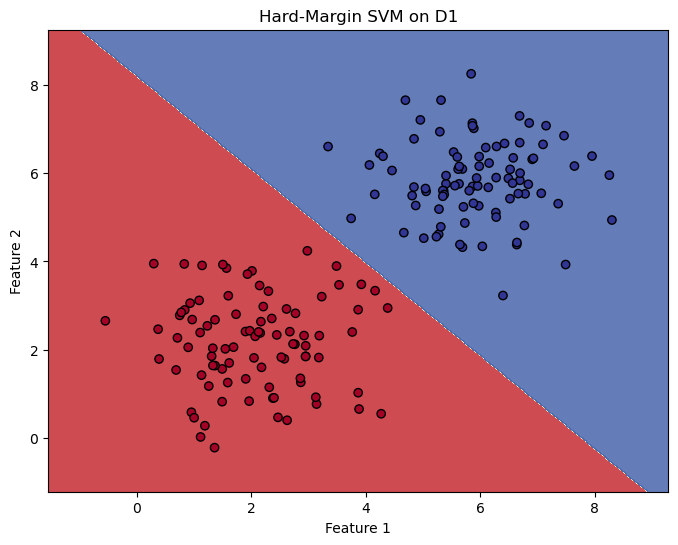

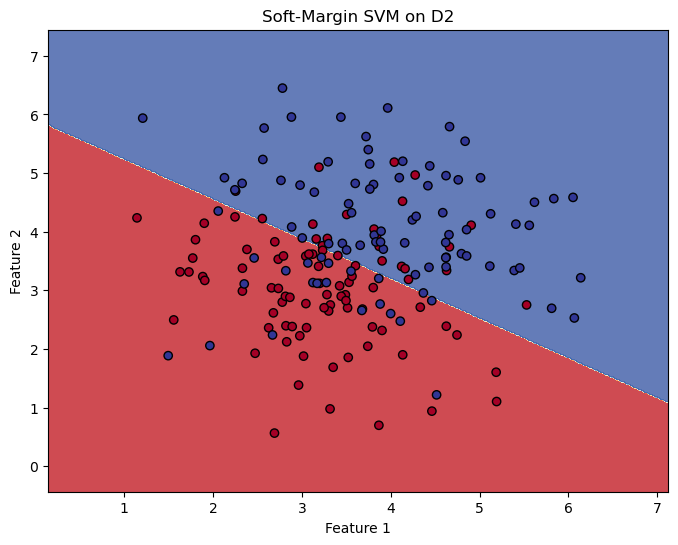

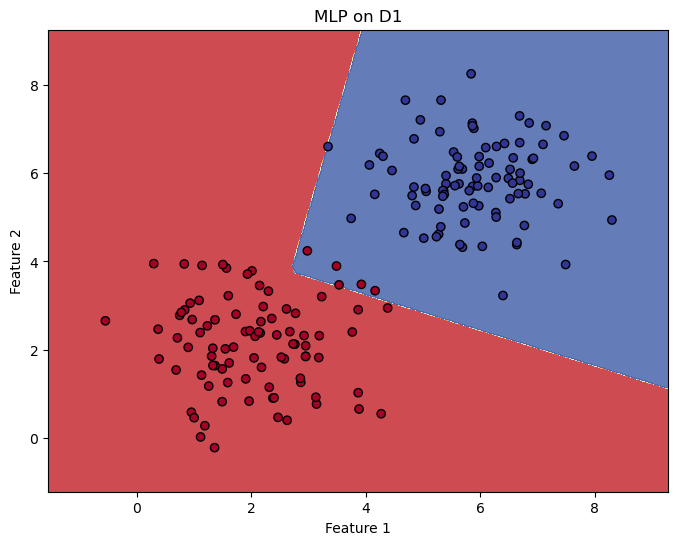

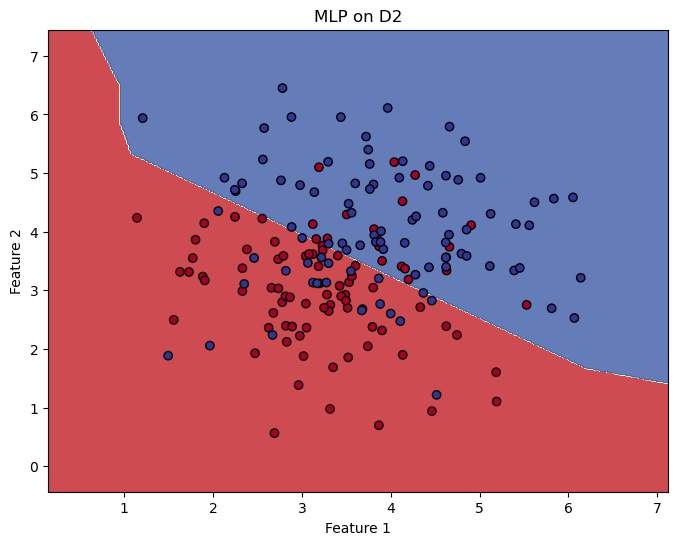

In [83]:
def plot_decision_boundary(X, y, model, title):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                           np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


# Hard-Margin SVM on D1
plot_decision_boundary(X1_train, y1_train, svm_hard, "Hard-Margin SVM on D1")

# Soft-Margin SVM on D2
plot_decision_boundary(X2_train, y2_train, svm_soft, "Soft-Margin SVM on D2")

# MLP on D1
plot_decision_boundary(X1_train, y1_train, mlp_d1, "MLP on D1")

# MLP on D2
plot_decision_boundary(X2_train, y2_train, mlp_d2, "MLP on D2")